In [15]:
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
import re
import emoji
from matplotlib import pyplot as plt
import math
from joblib import dump, load

stop_words = set(stopwords.words("english"))


In [16]:
fn = "group_8_automotive_data.csv"
data = pd.read_csv(fn, encoding='utf-8')

In [17]:
from nltk.corpus import wordnet

def negate(sentence):	
  '''
  Input: Tokenized sentence (List of words)
  Output: Tokenized sentence with negation handled (List of words)
  '''
  temp = int(0)
  for i in range(len(sentence)):
      if sentence[i-1] in ['not',"n't"]:
          antonyms = []
          for syn in wordnet.synsets(sentence[i]):
              syns = wordnet.synsets(sentence[i])
              w1 = syns[0].name()
              temp = 0
              for l in syn.lemmas():
                  if l.antonyms():
                      antonyms.append(l.antonyms()[0].name())
              max_dissimilarity = 0
              for ant in antonyms:
                  syns = wordnet.synsets(ant)
                  w2 = syns[0].name()
                  syns = wordnet.synsets(sentence[i])
                  w1 = syns[0].name()
                  word1 = wordnet.synset(w1)
                  word2 = wordnet.synset(w2)
                  if isinstance(word1.wup_similarity(word2), float) or isinstance(word1.wup_similarity(word2), int):
                      temp = 1 - word1.wup_similarity(word2)
                  if temp>max_dissimilarity:
                      max_dissimilarity = temp
                      antonym_max = ant
                      sentence[i] = antonym_max
                      sentence[i-1] = ''
  while '' in sentence:
      sentence.remove('')
  return sentence

negate(["not", "good"])

['evil']

In [18]:
def cleanly_tokenize(text):
  # Remove URLs
  text = re.sub(r"http\S+|www\S+|https\S+", "", text)
  
  # Remove HTML tags by getting parsed text
  text = BeautifulSoup(text, "html.parser").get_text()

  # Replace "n't" with " not"
  text = re.sub(r"n't", " not", text)

  # Remove non-letters (except emojis) and lowercase 
  pattern = r'[^a-zA-Z\U0001F600-\U0001F64F\U0001F300-\U0001F5FF\U0001F680-\U0001F6FF\U0001F1E0-\U0001F1FF]+'
  text = re.sub(pattern, " ", text).lower()
  
  # Replace emojis with text representation
  text = emoji.demojize(text, ["emoji_", " "])

  # Tokenize
  tokens = word_tokenize(text)
  
  # Handle negation
  tokens = negate(tokens)

  # Remove stopwords
  tokens = [i for i in tokens if i not in stop_words]

  # Remove tokens of length 1
  tokens = [i for i in tokens if len(i) > 1]

  # Stem
  stemmer = nltk.WordNetLemmatizer()
  tokens = [stemmer.lemmatize(i) for i in tokens]

  return tokens


In [19]:
cleanly_tokenize("It didn't fit my steering wheel. I returned 3 of them 😕")

['unfit', 'steering', 'wheel', 'returned', 'emoji_confused_face']

In [20]:
Df_nans = data.loc[data["product_title"].isna()]
len(Df_nans)
data.loc[data["product_title"].isna(), "product_title"] = ""

In [21]:
#462658 verified
#17146 not verified
data = data.loc[data["verified_purchase"] == "Y"]
print(data)

        customer_id       review_id  product_id  \
0          36075342   RAB23OVFNCXZQ  B00LPRXQ4Y   
1          42462164  R3NORADVJO6IE6  B000C7S0TO   
2          21241933  R299F4SO98S5OO  B000CO9WE4   
3          52570308  R2DA9DOT03UW6I  B000GKD5NI   
4          38200102  R2OGCH681EQHU6  B009SDA7TE   
...             ...             ...         ...   
479799     15623245  R2GRUWWFJJ4F9I  B005PO6NE8   
479800     15930665  R299IPNGB1ZTXZ  B00CUAWJ6G   
479801      8133858   RH3037BU3OSTQ  B00KHUQGGA   
479802     13955876  R1FYDRCCF1EPTI  B00G2Q6J6K   
479803      7543185  R39UXBGLPO8R8C  B00SXVNCDK   

                                            product_title product_category  \
0       17" 2003-2006 Ford EXPEDITION Ford F150 2004-2...       Automotive   
1       Spectra Premium CU1909 Complete Radiator for T...       Automotive   
2       K&N E-4665 High Performance Replacement Indust...       Automotive   
3                            Suncutters Rear Window Shade       Automotive 

In [22]:
# find all rows that have emoji in review_body
data[data['review_body'].str.contains('[\U0001F600-\U0001F6FF]')]["review_body"].sample(10).values

array(['😉',
       'It does not fit my car like the vendor said.  Its too big for the opening.  😕',
       'They are great...just what I want😎',
       'Did not fit properly , only had 11pcs. Not 15pcs. 😐',
       'So nice. The hid light so bright cool. 😎👍', '😀',
       'I love this Idem. So pretty on my new SUV. Great price and great for Florida😊',
       "Vinyl trim was an exact match to replace my weather stained trim around the three storage bins. The trim was used by my manufacture to cover the door's installation screws. Tip: Use a blow dryer to heat the vinyl and make it pliable  enough to bend into the retaining grooves. Manufacturer should have said that rather than our trial and error😀",
       'It is great!, people stop me in parking lots to ask where I bought it. 😉',
       "Love it it's exactly what I ordered 🔨💪🏼💯🙌🏼👌🏼💰😱😬😎👷🏼😷😷😷 But I just found out I have to buy the antiflicker for the hid kit now I gotta wait long to run my lights but worth the wait... Post a better pictur

In [23]:
def get_review_body(review_id):
  return cleanly_tokenize(data.loc[data["review_id"] == review_id]["review_body"].values[0])

get_review_body("R1CKCTN2BXKOBQ")

['work', 'great', 'emoji_grinning_face', 'emoji_grinning_face']

In [27]:
trunc = data
trunc['review_body'].head(10)

0    As it was used, the method that Ford used to a...
1    Put it in fine, no problems. Shipping was dece...
2          Fit wonderfully on my 36HP Pro-Drive motor.
3    Good for the price!  So far I have put it up i...
4    Fit perfectly on my 2012 Tundra with stock alu...
5    Product fits well and closely matches color of...
6            convenient ,fast delivery, and fair price
7                                              is good
8    wonderful.  if you need a locking cap, and we ...
9    Does not work with my Ford Taurus. But there's...
Name: review_body, dtype: object

In [25]:
# give me 10k random one star reviews
def get_by_star(star, n):
    return data[data["star_rating"] == star].sample(math.ceil(n))


def get_weights(t):
    base = [
        0.085047405,
        0.0387409,
        0.062817448,
        0.136370552,
        0.677023695,
    ]

    return [i * (1 - t) + 0.2 * t for i in base]


# using get_by_star give me one dataframe with equal amounts of star reviews
def get_equal_star(n, t):
    weights = get_weights(t)
    one = get_by_star(1, n * weights[0])
    two = get_by_star(2, n * weights[1])
    three = get_by_star(3, n * weights[2])
    four = get_by_star(4, n * weights[3])
    five = get_by_star(5, n * weights[4])
    return pd.concat([one, two, three, four, five]).sample(n)


# get data rows not in trunc
def get_not_trunc(trunc):
    return data.loc[~data["review_id"].isin(trunc["review_id"])]


def get_data(n, k, t):
    train = get_equal_star(n, t)
    print(train["star_rating"].value_counts())
    test = get_not_trunc(train).sample(k)
    return pd.concat([train, test])


trunc = get_data(50000, 10000, 0.75)


star_rating
5    15963
4     9202
1     8564
3     8286
2     7985
Name: count, dtype: int64


In [28]:
vectorizer = TfidfVectorizer(
  # stop_words="english", 
  # strip_accents="unicode", 
  # lowercase=True, 
  tokenizer=cleanly_tokenize,
  ngram_range=(1, 1), 
  max_features=2000
)

counts = vectorizer.fit_transform(trunc["review_body"]).toarray()
words = vectorizer.get_feature_names_out()
print(words)

# print words that contain _ (emojis)
print([word for word in words if "emoji_" in word])

df_tf_idf = pd.DataFrame(counts, columns=words)

# don't do .todense()?


C:\Users\stijn\AppData\Local\Temp\ipykernel_24288\4022872324.py:6: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "html.parser").get_text()


['ab' 'ability' 'able' ... 'zero' 'zip' 'zipper']
['emoji_thumbs_up']


In [29]:
dump(df_tf_idf, "50k_10k_tf_idf_75pc.joblib")

['50k_10k_tf_idf_75pc.joblib']

In [ ]:
#We split our star ratings into two categories: negative and positive. Star rating 1 to 3 get 'negative' and 4 to 5 get 'positive'
trunc.loc[trunc["star_rating"].isin([1,2,3]), "star_rating"] = 'negative'
trunc.loc[trunc["star_rating"].isin([4,5]), "star_rating"] = 'positive'

In [31]:
import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC, LinearSVC
from joblib import load
from sklearn.metrics import accuracy_score


n_split = 400000

X_train = df_tf_idf[:n_split]
y_train = trunc["star_rating"][:n_split]
X_test = df_tf_idf[n_split:]
y_test = trunc["star_rating"][n_split:]


classifier = LogisticRegression(max_iter=1000)
classifier.fit(X_train, y_train)
#classifier = load("50k_10k_logistic_75pc.joblib")

predictions = classifier.predict(X_test)
accuracy_score(y_test, predictions)


0.7469596859140094

In [ ]:
dump(classifier, "50k_10k_tf_idf_75pc.joblib")

['50k_10k_tf_idf_75pc.joblib']

In [ ]:
data.describe()

,customer_id,star_rating
count,4.626580e+05,462658.000000
mean,2.371276e+07,4.297336
std,1.615771e+07,1.241507
min,1.000400e+04,1.000000
25%,1.072022e+07,4.000000
50%,2.152597e+07,5.000000
75%,3.852885e+07,5.000000
max,5.309612e+07,5.000000


In [36]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
#from sklearn.model_selection import GridSearchCV
#from sklearn.preprocessing import StandardScaler

# nn_clf = MLPClassifier()
# params = {
#     'solver': ['adam'],
#     'alpha': [10.0**-5],
#     'hidden_layer_sizes': [2, 4, 6, 8],
#     'random_state': [1]
# }
# classifier = GridSearchCV(estimator=nn_clf, param_grid=params, n_jobs=10, verbose=3)

classifier = MLPClassifier(solver="adam", alpha=1e-5, hidden_layer_sizes=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2), random_state=1, max_iter=1000)
classifier.fit(X_train, y_train)
predictions = classifier.predict(X_test)
accuracy_score(y_test, predictions)

0.684717035334674

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, predictions)

0.8619

In [38]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test, predictions, squared=False)

1.4094658174799597

In [37]:
from sklearn.metrics import f1_score
f1_score(y_test, predictions, average='macro')

0.1625714042117828

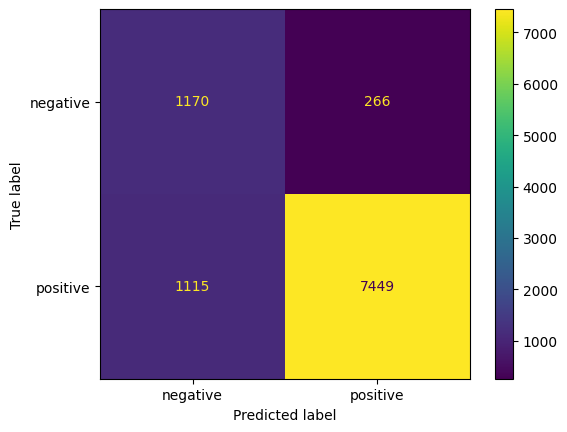

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(classifier, X_test, y_test)

plt.show()

In [ ]:
import random

# Define the number of random rows to view
n = 5

# Get random indices from the test set
random_idx = round(random.random() * len(X_test))


# Retrieve the corresponding sample and its information
sample_text = trunc.iloc[X_test.index[random_idx]]['review_body']
sample_tokenized = cleanly_tokenize(sample_text)
sample_real_stars = y_test.iloc[random_idx] 
sample_predicted_stars = predictions[random_idx]  

# Print the sample information
print("Sample Text:", sample_text)
print("Tokenized Text:", sample_tokenized)
print("Real Stars:", sample_real_stars)
print("Predicted Stars:", sample_predicted_stars)

Sample Text: Bed worked great. I had ordered the full size bed for my truck but got a skinnier version which happened to work out better.This left me room on one side to but my bags. So far very happy with this bed.
Tokenized Text: ['bed', 'worked', 'great', 'ordered', 'full', 'size', 'bed', 'truck', 'got', 'skinnier', 'version', 'happened', 'work', 'better', 'left', 'room', 'one', 'side', 'bag', 'far', 'happy', 'bed']
Real Stars: positive
Predicted Stars: positive


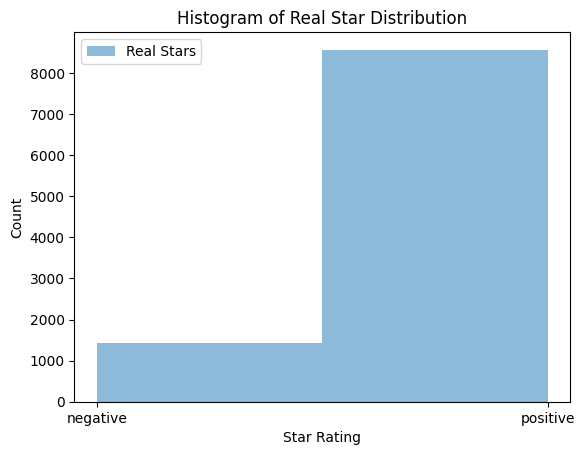

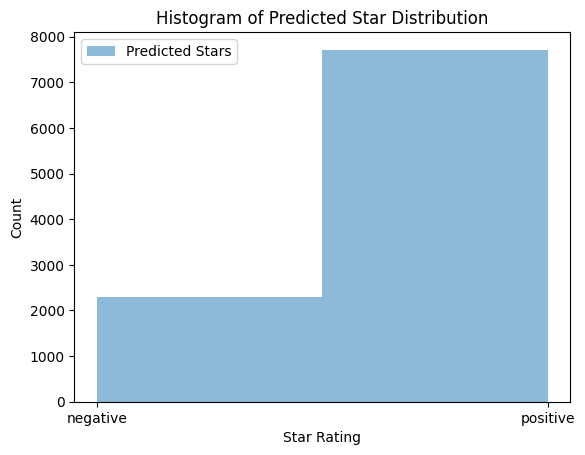

In [ ]:
# Plot the histogram of real star distribution
plt.hist(y_test, bins=2, alpha=0.5, label='Real Stars')
plt.xlabel('Star Rating')
plt.ylabel('Count')
plt.title('Histogram of Real Star Distribution')
plt.legend()
plt.show()

# Plot the histogram of predicted star distribution
plt.hist(predictions, bins=2, alpha=0.5, label='Predicted Stars')
plt.xlabel('Star Rating')
plt.ylabel('Count')
plt.title('Histogram of Predicted Star Distribution')
plt.legend()
plt.show()


In [ ]:
stars = data['star_rating']
print(len(stars.loc[stars == 1]))
print(len(stars.loc[stars == 2]))
print(len(stars.loc[stars == 3]))
print(len(stars.loc[stars == 4]))
print(len(stars.loc[stars == 5]))

37701
17672
29003
63267
315015


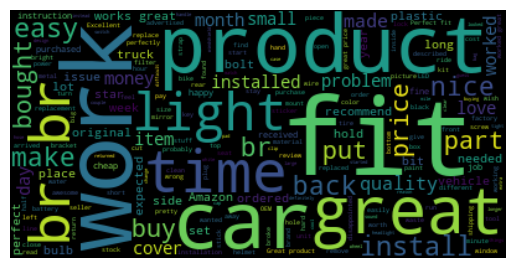

In [ ]:
from matplotlib import pyplot as plt
from wordcloud import WordCloud

textt = " ".join(review for review in trunc['review_body'])
wordcloud = WordCloud(stopwords=stopwords.words()).generate(textt)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
print(stopwords)

<WordListCorpusReader in 'C:\\Users\\stijn\\AppData\\Roaming\\nltk_data\\corpora\\stopwords'>


In [ ]:
def readFile(fileName):
  #Reads the file, the proper encoding is to prevent problems
  return pd.read_csv(fileName, encoding="utf−8")

In [ ]:
punctuation = string.punctuation

def cleanData(data):
  #Replace missing data with "" in product_title
  data["product_title"] = data["product_title"].fillna("")

  n = len(data["review_body"])
  #for i in np.arange(n):
  #  data["review_body"][i] = BeautifulSoup(data["review_body"][i], "html.parser")

  #Remove the capital letters to prevent miscounting the frequency of words
  data["review_body"] = data["review_body"].str.lower()

  #Remove punctuation so that we can later split the data properly into words by only consider spaces
  data["review_body"] = data["review_body"].apply(lambda data: removePunctuation(data))

  testData = data["review_body"][0:100]
 
  stopwords = set(stopwords.words("english"))
  doc_string = testData.loc[0, "text"]
  print(doc_string)
  


def removePunctuation(text):
    return text.translate(str.maketrans('', '', punctuation))


In [ ]:
def main():
  file = readFile("group_8_automotive_data.csv")
  #print(file.head())

  #Results below show that approximately all data is inserted,
  #except for product_title where approximately 0.0015% is missing
  #print(file.isnull().mean())

  #All variables are intepreted as 'object', except for 'customer_id' and 'star_rating' which are seen as 'int64'. This is fine if we consider the data

  #print(file.dtypes)

  #print(file.min())
  #print(file.max())


  cleanData(file)

main()

UnboundLocalError: cannot access local variable 'stopwords' where it is not associated with a value